In [91]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [92]:
customers_df = pd.read_csv('/content/Customers.csv')
products_df = pd.read_csv('/content/Products.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')
print(customers_df.head())
print(transactions_df.head())
print(products_df.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  
  ProductID              ProductName     Category   Price
0      P001

In [93]:
merged_data = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')
merged_data = pd.merge(merged_data, products_df[['ProductID', 'Category']], on='ProductID', how='left')
print(merged_data.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate     Category  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  Electronics  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  Electronics  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  Electronics  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  Electronics  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  Electronics  


In [94]:
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])

customer_summary = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    most_recent_transaction=('TransactionDate', 'max')
).reset_index()

In [95]:
import datetime
customer_summary['recency'] = (datetime.datetime.now() - customer_summary['most_recent_transaction']).dt.days
customer_data = pd.merge(customers_df, customer_summary, on='CustomerID', how='left')
print(customer_data.head())

  CustomerID        CustomerName         Region  SignupDate  total_spent  \
0      C0001    Lawrence Carroll  South America  2022-07-10      3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13      1862.74   
2      C0003      Michael Rivera  South America  2024-03-07      2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09      5354.88   
4      C0005         Laura Weber           Asia  2022-08-15      2034.24   

   transaction_count most_recent_transaction  recency  
0                5.0     2024-11-02 17:04:16     86.0  
1                4.0     2024-12-03 01:41:41     55.0  
2                4.0     2024-08-24 18:54:04    155.0  
3                8.0     2024-12-23 14:13:52     35.0  
4                3.0     2024-11-04 00:30:22     84.0  


In [96]:
features = customer_data[['total_spent', 'transaction_count', 'recency']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print(scaled_features[:5, :])

[[-0.06170143 -0.01145819 -0.25572408]
 [-0.87774353 -0.46749414 -0.69381401]
 [-0.40585722 -0.46749414  0.71937931]
 [ 1.03254704  1.35664965 -0.97645267]
 [-0.78392861 -0.92353008 -0.28398794]]


In [97]:
missing_values = features.isnull().sum()
print(missing_values)

total_spent          1
transaction_count    1
recency              1
dtype: int64


In [98]:
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)
features_imputed_df = pd.DataFrame(features_imputed, columns=features.columns)
print(features_imputed_df)

     total_spent  transaction_count  recency
0        3354.52                5.0     86.0
1        1862.74                4.0     55.0
2        2725.38                4.0    155.0
3        5354.88                8.0     35.0
4        2034.24                3.0     84.0
..           ...                ...      ...
195      4982.88                4.0     43.0
196      1928.65                3.0     30.0
197       931.83                2.0    114.0
198      1979.28                4.0     93.0
199      4758.60                5.0     47.0

[200 rows x 3 columns]


In [99]:
features_dropped = features.dropna()
print(features_dropped)

     total_spent  transaction_count  recency
0        3354.52                5.0     86.0
1        1862.74                4.0     55.0
2        2725.38                4.0    155.0
3        5354.88                8.0     35.0
4        2034.24                3.0     84.0
..           ...                ...      ...
195      4982.88                4.0     43.0
196      1928.65                3.0     30.0
197       931.83                2.0    114.0
198      1979.28                4.0     93.0
199      4758.60                5.0     47.0

[199 rows x 3 columns]


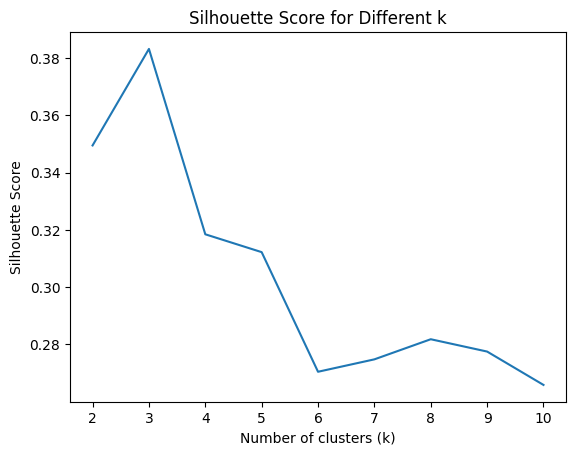

In [100]:
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_imputed)
    silhouette_avg = silhouette_score(scaled_features_imputed, kmeans.labels_)
    silhouettes.append(silhouette_avg)

plt.plot(k_range, silhouettes)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

In [101]:
kmeans_final = KMeans(n_clusters=3, random_state=42)
customer_data['cluster'] = kmeans_final.fit_predict(scaled_features_imputed)

db_index = davies_bouldin_score(scaled_features_imputed, customer_data['cluster'])
print(f'Davies-Bouldin Index: {db_index}')

silhouette_avg = silhouette_score(scaled_features_imputed, customer_data['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Davies-Bouldin Index: 0.8812020904812945
Silhouette Score: 0.38318610099914624


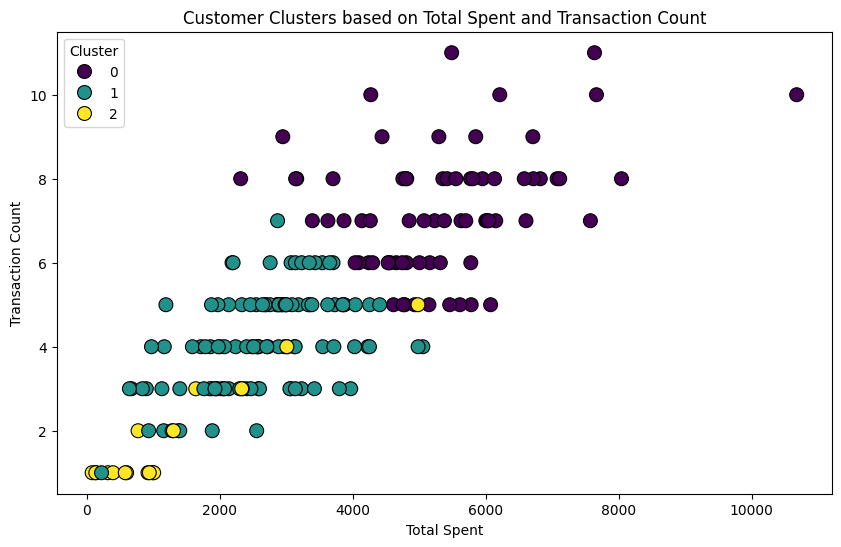

In [102]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_spent', y='transaction_count', hue='cluster', data=customer_data, palette='viridis', s=100, edgecolor='k')
plt.title('Customer Clusters based on Total Spent and Transaction Count')
plt.xlabel('Total Spent')
plt.ylabel('Transaction Count')
plt.legend(title='Cluster')
plt.show()

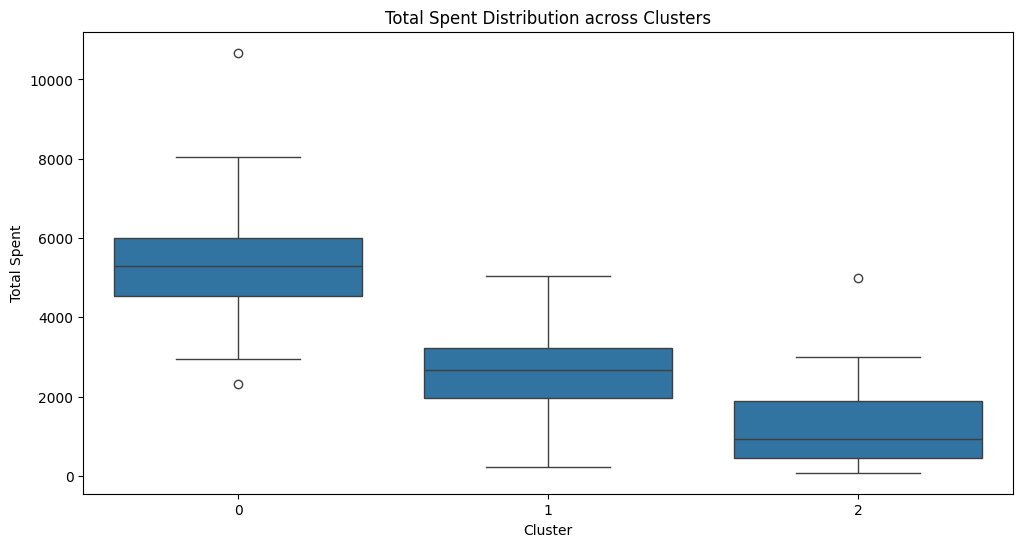

In [103]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='total_spent', data=customer_data)
plt.title('Total Spent Distribution across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Total Spent')
plt.show()


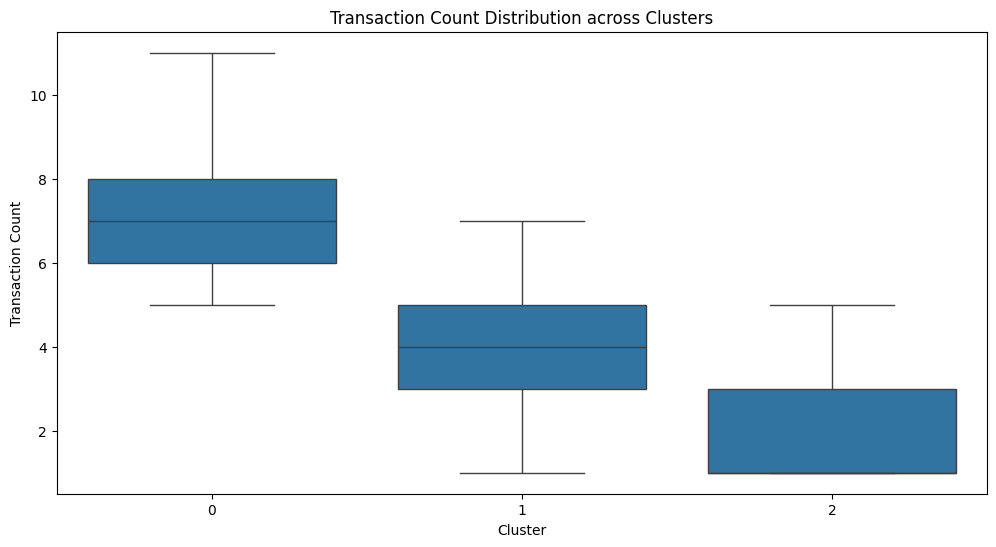

In [104]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='transaction_count', data=customer_data)
plt.title('Transaction Count Distribution across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Transaction Count')
plt.show()


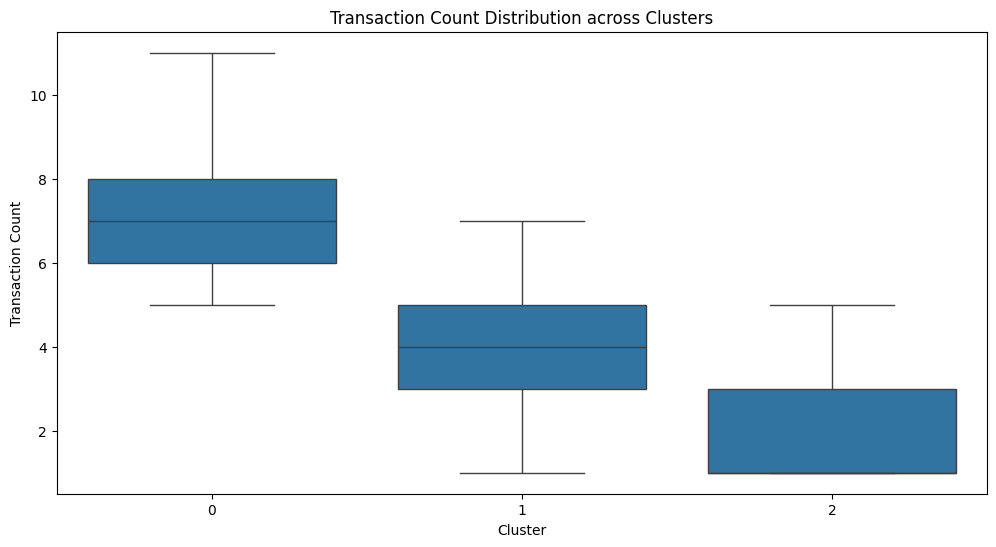

In [105]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='transaction_count', data=customer_data)
plt.title('Transaction Count Distribution across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Transaction Count')
plt.show()
